In [37]:
import csv
import mysql.connector
from random import randint
from random import randrange
from random import sample
import datetime
import pandas as pd
import numpy as np
from itertools import chain
from sqlalchemy import create_engine
import sqlalchemy as db
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import urllib.parse
from numpy import *
from flask import Flask
import random
import pymysql
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter as SMF
import sys


In [3]:
import csv
import mysql.connector
from random import randint
from random import randrange
from random import sample
import datetime

# Raport

# Zadanie 1

Pierwszym zagadnieniem do analizy jest narysowanie wykresu z ilością meczy które się odbyły w poszczególnych miesiącach działania klubu. Korzystamy z poniższego kodu MySQL, żeby wybrać dane z ilością meczy w każdym miesięcu. Następnie wyświetlamy wykres słupkowy.

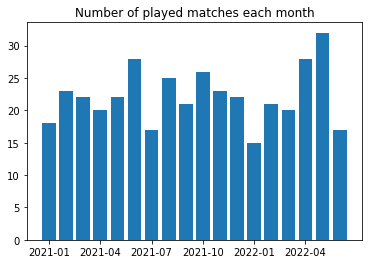

In [9]:


#Connecting to database
if __name__ == "__main__":
    mydb = mysql.connector.connect(
        host = 'giniewicz.it',
        user = 'team21',
        database = 'team21',
        password = 'te@mZIP@ss'
    )
    mycursor = mydb.cursor()
    
    
#Selecting match counts for each months from match_results
    sql = "SELECT \
            DATE_FORMAT(match_date, '%Y-%m') as match_month,  \
            COUNT(*) \
        FROM match_results \
        GROUP BY match_month \
        ORDER BY match_date;"
    mycursor.execute(sql)        #making barplot
    tmp = mycursor.fetchall()
    months = [x[0] for x in tmp]
    numMatches = [x[1] for x in tmp]
    months_pos = np.arange(len(months))
    x_pos = []
    x_ticks = []
    for i in range(len(months)):
        if i%3 == 0:
            x_pos.append(months_pos[i])
            x_ticks.append(months[i])
    plt.bar(months_pos, numMatches)
    plt.xticks(x_pos, x_ticks)
    plt.title("Number of played matches each month")
    plt.show()
    

Teraz w analogiczny sposób robimy wykres słupkowy dla ilości meczy zaplanowanych na przyszłość na poszczególne miesiące

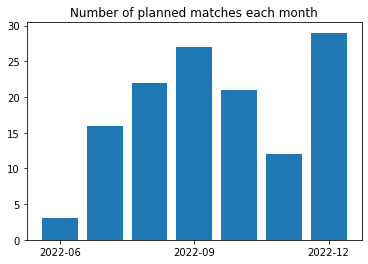

In [10]:
#Connecting to database
if __name__ == "__main__":
    mydb = mysql.connector.connect(
        host = 'giniewicz.it',
        user = 'team21',
        database = 'team21',
        password = 'te@mZIP@ss'
    )
    mycursor = mydb.cursor()    
    #Selecting match counts for each months from upcoming matches
    sql = "SELECT \
    DATE_FORMAT(match_date, '%Y-%m') as match_month, \
    COUNT(*) \
    FROM upcoming_matches \
    GROUP BY match_month \
    ORDER BY match_date;"
    mycursor.execute(sql)
    tmp1 = mycursor.fetchall()
    months1 = [x[0] for x in tmp1]
    numMatches1 = [x[1] for x in tmp1]
    months_pos1 = np.arange(len(months1))    #making barplot
    x_pos1 = []
    x_ticks1 = []
    for i in range(len(months1)):
        if i%3 == 0:
            x_pos1.append(months_pos1[i])
            x_ticks1.append(months1[i])
    plt.bar(months_pos1, numMatches1)
    plt.xticks(x_pos1, x_ticks1)
    plt.title("Number of planned matches each month")
    plt.show()
    



## Zadanie 2

### Przygotuj wykres przedstawiający bilans wygranych i przegranych drużyny.

Żeby przygotować taki wykres, pobraliśmy 4 kolumny z naszej bazy danych: team1, team2, team1_points, team2_points i zapisaliśmy do jednej tabeli pandas DataFrame.Następna analiza będzię dotoczyła tylko drużyn z naszego klubu.

In [11]:
db_connection = mysql.connector.connect(host='giniewicz.it', port= '3306', database='team21', user='team21', password='te@mZIP@ss')
db_cursor = db_connection.cursor() 

db_cursor.execute('SELECT team1 FROM match_results') #pobieranie danych z kolumny team1
table_rows1 = db_cursor.fetchall()
df1 = pd.DataFrame(table_rows1)

db_cursor.execute('SELECT team2 FROM match_results') #pobieranie danych z kolumny team2
table_rows2 = db_cursor.fetchall()
df2 = pd.DataFrame(table_rows2)

db_cursor.execute('SELECT team1_points FROM match_results') #pobieranie danych z kolumny team1_points
table_rows3 = db_cursor.fetchall()
df3 = pd.DataFrame(table_rows3)

db_cursor.execute('SELECT team2_points FROM match_results') #pobieranie danych z kolumny team2_points
table_rows4 = db_cursor.fetchall()
df4 = pd.DataFrame(table_rows4)

db_cursor.execute('SELECT player_surname FROM players WHERE position= %s', ('skip',)) # pobieranie nazw drużyn naszego klubu
table_rows5 = db_cursor.fetchall()
df5 = pd.DataFrame(table_rows5)


In [12]:
concatenated_df = pd.concat([df1, df2, df3, df4], axis = 1)
concatenated_df.columns = ['team1', 'team2', 'score1', 'score2'] #tworzenie tabeli

In [13]:
print('Stworzona tabela potrzebna do podalszej analizy przedstawiona poniżej')
concatenated_df

Stworzona tabela potrzebna do podalszej analizy przedstawiona poniżej


team1      team2  score1  score2
0    Halvarsson     Flodin       0      15
1        Ekblom   Selander      13       1
2      Ivarsson     Norlin      12       5
3          Lund   Mossberg      14      11
4      Lindblom  Stenström      12      13
..          ...        ...     ...     ...
395    Lindblom   Tornberg       6       7
396    Tornberg      Stolt      14       6
397       Melin     Ekblom       2       1
398      Nelson   Tornberg       9      12
399    Mossberg       Lund       4      15

[400 rows x 4 columns]

In [14]:
def check_if_team1_win(df):
    """
    Funkcja do sprawdzaania czy drużyna otrzymała więcej punktów czyli wygrała
    Args:
    -df - tabela z danymi
    Return
    - True (jeżeli drużyna wygrała)
    - False (jeżeli drużyna przegrała)
    """
    return df['score1'] > df['score2']

W dalszej częśći tworzymy nową tabele z nazwą drużyny, procentem wygranych meczy i procentem przegranych meczy

In [16]:
wins = []
loses = []
result_dict={}
for team in df5[0]:
    win_team1 = check_if_team1_win(concatenated_df[concatenated_df['team1'] == team]) # sprawdzenie ile razy drużyna w kołumnie team1 wygrałą
    win_team2 = ~check_if_team1_win(concatenated_df[concatenated_df['team2'] == team]) # sprawdzenie ile razy drużyna w kołumnie team2 wygrałą
    team_wins = win_team1.append(win_team2) 
    result_dict[team] = sum(team_wins)/len(team_wins)*100 # wyliczenie sumy wygranych meczy
    wins.append(sum(team_wins)/len(team_wins)*100) # wyliczenie procentu wygranych meczy i didawanie do jednej listy
    loses.append(100- sum(team_wins)/len(team_wins)*100) # wyliczenie procentu przegranych meczy i didawanie do jednej listy
plot_res=pd.DataFrame({'team': df5[0], # tworzenie nowej tabeli
             'wins': wins,
             'loses': loses})

<ipython-input-16-349a23d455a5>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_wins = win_team1.append(win_team2)
<ipython-input-16-349a23d455a5>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_wins = win_team1.append(win_team2)
<ipython-input-16-349a23d455a5>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_wins = win_team1.append(win_team2)
<ipython-input-16-349a23d455a5>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_wins = win_team1.append(win_team2)
<ipython-input-16-349a23d455a5>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [17]:
print('Tabela przedstawiająca nazwę drużyny oraz procent wygranych meczy i przegranych meczy ')
print(plot_res)

Tabela przedstawiająca nazwę drużyny oraz procent wygranych meczy i przegranych meczy 
          team       wins      loses
0     Lindblom  50.000000  50.000000
1   Halvarsson  52.830189  47.169811
2     Ivarsson  48.148148  51.851852
3       Ekblom  46.296296  53.703704
4       Nelson  45.238095  54.761905
5       Norlin  53.191489  46.808511
6     Tornberg  50.847458  49.152542
7      Östlund  63.636364  36.363636
8        Melin  53.061224  46.938776
9     Burström  54.716981  45.283019
10   Cedergren  61.538462  38.461538
11     Östling  25.000000  75.000000
12       Vidén  47.826087  52.173913
13    Selander  51.785714  48.214286
14    Mossberg  37.500000  62.500000
15        Lund  48.837209  51.162791


Poniżej znajduję się część, gdzie tworzymy wykres przedstawiający bilans wygranych i przegranych drużyny.

In [18]:

#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
plot_res.set_index('team').plot(kind='bar', stacked=True, color=['green', 'red'],figsize=(10,8))

#add overall title
plt.title('Bilans wygranych i przegranych meczy', fontsize=16)

#add axis titles
plt.xlabel('Team')
plt.ylabel('Procent wygranych i przegranych meczy')

#rotate x-axis labels
plt.xticks(rotation=100)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

### Wniosek
Z powyższego wykresu możemy wywnioskować, że w naczym klubie zachowuję się bilans wygranuch i przegranych meczy.

## Zadanie 3

Z racji tego, że nie uwzględnialiśmy zmian ani rotacji personalnych w składach, to w każdym z meczów nasze drużyny grały w jednakowych i niezmienionych składach. 
W związku z tym zdecydowaliśmy, że zamiast listy najlepszych zawodników przygotujemy listę najlepszych drużyn w naszym klubie.

Najlepszą drużyną będzie dla nas ta, która ma najlepszy stosunek wygranych do wszystkich rozegranych meczów.
Jednak żeby drużyna była brana pod uwagę, musi ona rozegrać przynajmniej 25 spotkań. Gdy nie rozegra ona tej ustalonej przez nas liczby spotkań, nie będzie w ogóle uwzględniana w naszym rankingu. 

In [19]:
#tworzenie połączenia z bazą
user = 'team21'
password = urllib.parse.quote_plus('te@mZIP@ss')  
host = 'giniewicz.it'
port = 3306
database = 'team21'

engine = db.create_engine("mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database))
connection = engine.connect()

In [20]:
# pobieranie rezultaty
rezultaty = db.Table('match_results',db.MetaData(), autoload=True, autoload_with=engine)
dataframe_rez = pd.read_sql(db.select([rezultaty]), engine.connect())

In [21]:
# pobieranie drużyn
druzyny = db.Table('players',db.MetaData(), autoload=True, autoload_with=engine)
dataframe_dr = pd.read_sql(db.select([druzyny]), engine.connect())

In [22]:
#tworzenie słownika z wszystkimi drużynami w naszym klubie
druzyny = []
for i in dataframe_dr.team:
    if i not in druzyny:
        druzyny.append(i)
druzyny_slownik = []
for d in druzyny:
    druzyny_slownik.append({"drużyna": f"{d}"})

In [23]:
#dodawanie do słownika ilości wygranych i rozegranych meczów 
for druz in druzyny_slownik:
    dr = druz["drużyna"]
    wygrane = 0
    mecze = 0
    for i in range(len(dataframe_rez)):
        if dr == dataframe_rez.team1[i] or dr == dataframe_rez.team2[i]:
            mecze += 1
            if dr == dataframe_rez.team1[i]:
                if dataframe_rez.team1_points[i] > dataframe_rez.team2_points[i]:
                    wygrane += 1
            if dr == dataframe_rez.team2[i]:
                if dataframe_rez.team2_points[i] > dataframe_rez.team1_points[i]:
                    wygrane += 1
                    
    druz["wygrane"] = f"{wygrane}"                                    
    druz["mecze"] = f"{mecze}"
    druz["wygrane/mecze"] = f"{round(wygrane/mecze,4)}"

In [24]:
#warunek przynajmniej 25 meczów
druzyny_slownik_wygrane25 = []
for d in druzyny_slownik:
    if int(d["mecze"]) >= 25:  
        druzyny_slownik_wygrane25.append(d)

In [25]:
druzyny_slownik_wygrane25 = sorted(druzyny_slownik_wygrane25, key=lambda d: d['wygrane/mecze']) #sortowanie
druzyny_slownik_wygrane25.reverse() #odwracanie kolejnośći

In [26]:
df = pd.DataFrame(druzyny_slownik_wygrane25)
print(df)

       drużyna wygrane mecze wygrane/mecze
0    Cedergren      24    39        0.6154
1     Burström      29    53        0.5472
2       Norlin      25    47        0.5319
3        Melin      26    49        0.5306
4   Halvarsson      28    53        0.5283
5     Selander      29    56        0.5179
6     Tornberg      30    59        0.5085
7     Lindblom      22    44           0.5
8         Lund      21    43        0.4884
9     Ivarsson      26    54        0.4815
10       Vidén      22    46        0.4783
11      Ekblom      25    54         0.463
12      Nelson      19    42        0.4524
13    Mossberg      18    48         0.375


In [27]:
print(f"Zatem najlepszą drużyną w naszym klubie jest drużyna {df.drużyna[0]} z liczbą wygranych meczów równą {df.wygrane[0]}, liczbą wszystkich meczów: {df.mecze[0]} oraz stosunkiem wygranych do rozegranych meczów wynoszącym {df['wygrane/mecze'][0]}.")

Zatem najlepszą drużyną w naszym klubie jest drużyna Cedergren z liczbą wygranych meczów równą 24, liczbą wszystkich meczów: 39 oraz stosunkiem wygranych do rozegranych meczów wynoszącym 0.6154.


## Zadanie 4

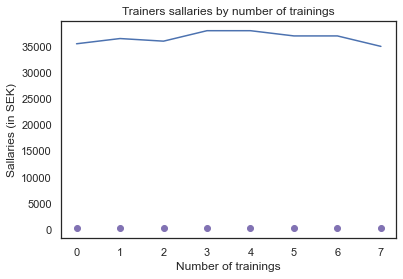

id trenera: 3, ilość treningów: 221, wypłata: 35500SEK
id trenera: 4, ilość treningów: 223, wypłata: 36500SEK
id trenera: 6, ilość treningów: 217, wypłata: 36000SEK
id trenera: 7, ilość treningów: 217, wypłata: 38000SEK
id trenera: 9, ilość treningów: 219, wypłata: 38000SEK
id trenera: 12, ilość treningów: 227, wypłata: 37000SEK
id trenera: 18, ilość treningów: 207, wypłata: 37000SEK
id trenera: 19, ilość treningów: 210, wypłata: 35000SEK

Nie widać zależności pomiędzy ilością treningów a wypłatą.
Jest to zgodne z oczekiwaniami ponieważ dane były generowane losowo.


In [30]:
#połączenie z bazą
try:
	conn = mysql.connector.connect(
		user="team21",
		password="te@mZIP@ss",
		host="giniewicz.it",
		port=3306,
		database="team21"
	)
except mariadb.Error as e:
	print("Connection failed")
	sys.exit(1)

cur = conn.cursor()

#wywołanie zapytania
cur.execute(
	"SELECT trainer, sallary, COUNT(training_id) as 'Num_trainings' FROM employees  RIGHT JOIN trainings ON employee_id = trainer GROUP BY trainer;"
)

#wpisanie pobranych danych do wektorów
sallaries=[]
number_of_trainings=[]
trainer_id=[]

for (trainer, sallary, Num_trainings) in cur:
	sallaries.append(sallary)
	number_of_trainings.append(Num_trainings)
	trainer_id.append(trainer)


#tworzenie wykresu
plt.plot(number_of_trainings,'mo',sallaries)
plt.ylabel('Sallaries (in SEK)')
plt.xlabel('Number of trainings')
plt.gca().xaxis.set_major_formatter(SMF('{x:,.0f}'))
plt.title('Trainers sallaries by number of trainings')
plt.show()

#wypisanie danych
for i in range(len(sallaries)):
	print(f"id trenera: {trainer_id[i]}, ilość treningów: {number_of_trainings[i]}, wypłata: {sallaries[i]}SEK")
print("\nNie widać zależności pomiędzy ilością treningów a wypłatą.\nJest to zgodne z oczekiwaniami ponieważ dane były generowane losowo.")




## Zadanie 5
### Testowanie średniej ilości uzbieranych punktów w meczu dla drużyn męskich i żeńskich
Żeby odpowieźć na pytanie czy różni się średnia ilość uzbieranych punktów w meczy dla drużyn męskich i żeńskich, pobraliśmy kolumny z naszej bazy danych odnośnie uzbieranych punktów kiedy typ meczu jest "men" i "junior men" oraz "women" i "junior women". Ponieżej przedstawiony postęp pracy.

In [31]:
if __name__ == "__main__":
    mydb = mysql.connector.connect(
        host = 'giniewicz.it',
        user = 'team21',
        database = 'team21',
        password = 'te@mZIP@ss' # connection to database
    )
    mycursor = mydb.cursor()
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('men',)) 
    result = mycursor.fetchall() #data about team_1 points when match type = 'men'
    mylist = list(chain.from_iterable(result)) # created lits of points
    
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('men',))
    result1 = mycursor.fetchall() #data about team_2 points when match type = 'men'
    mylist += list(chain.from_iterable(result1)) # adding points to list
    
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('junior men',))
    result2 = mycursor.fetchall() #data about team_1 points when match type = 'junior men'
    mylist += list(chain.from_iterable(result2)) # adding points to list
    
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('junior men',))
    result3 = mycursor.fetchall() #data about team_2 points when match type = 'junior men'
    mylist += list(chain.from_iterable(result3)) # adding points to list
    
    mean1= np.mean(mylist) # mean of list
    mydb.commit()
    print('Średnia ilość uzbieranych punktów w meczu dla drużyn męskich =',mean1) # print result

Średnia ilość uzbieranych punktów w meczu dla drużyn męskich = 7.485294117647059


In [32]:
if __name__ == "__main__":
    mydb = mysql.connector.connect(
        host = 'giniewicz.it',
        user = 'team21',
        database = 'team21',
        password = 'te@mZIP@ss' # connection to database
    )
    mycursor = mydb.cursor()
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('women',))
    result = mycursor.fetchall() #data about team_1 points when match type = 'women'
    mylist = list(chain.from_iterable(result)) # created lits of points
    
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('women',))
    result1 = mycursor.fetchall() #data about team_2 points when match type = 'women'
    mylist += list(chain.from_iterable(result1)) # adding points to list
    
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('junior women',))
    result2 = mycursor.fetchall() #data about team_1 points when match type = 'junior women'
    mylist += list(chain.from_iterable(result2)) # adding points to list
    
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('junior women',))
    result3 = mycursor.fetchall() #data about team_2 points when match type = 'junior women'
    mylist += list(chain.from_iterable(result3)) # adding points to list
    
    mean1= np.mean(mylist) # mean of list
    mydb.commit()
    print('Średnia ilość uzbieranych punktów w meczu dla drużyn żeńskich =',mean1) # print result

Średnia ilość uzbieranych punktów w meczu dla drużyn żeńskich = 7.292307692307692


### Wniosek
Otrzymaliśmy dość podobne wyniki. Czyli możemy wywnioskować, że średnie uzbieranych punktów różnią się nieistotnie.

## Zadanie 6
### Testowanie średniej ilości uzbieranych punktów w meczu dla drużyn juniorskich i dorosłych
Żeby odpowieźć na pytanie czy różni się średnia ilość uzbieranych punktów w meczy dla drużyn juniorskich i dorosłych, pobraliśmy kolumny z naszej bazy danych odnośnie uzbieranych punktów kiedy typ meczu jest "men",'mixed', 'mixed doubles', "women" oraz 'junior men', 'junior women', 'junior mixed'. Ponieżej przedstawiony postęp pracy.

In [33]:
if __name__ == "__main__":
    mydb = mysql.connector.connect(
        host = 'giniewicz.it',
        user = 'team21',
        database = 'team21',
        password = 'te@mZIP@ss' # connection to database
    )
    mycursor = mydb.cursor()
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('men',)) 
    result = mycursor.fetchall() #data about team_1 points when match type = 'men'
    mylist = list(chain.from_iterable(result)) # created lits of points
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('men',))
    result1 = mycursor.fetchall() #data about team_2 points when match type = 'men'
    mylist += list(chain.from_iterable(result1)) # adding points to list
    
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('mixed',))
    result2 = mycursor.fetchall() #data about team_1 points when match type = mixed'
    mylist += list(chain.from_iterable(result2)) # adding points to list
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('mixed',))
    result3 = mycursor.fetchall() #data about team_2 points when match type = mixed'
    mylist += list(chain.from_iterable(result3)) # adding points to list
    
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('mixed doubles',))
    result4 = mycursor.fetchall() #data about team_1 points when match type = ''mixed doubles'
    mylist += list(chain.from_iterable(result4)) # adding points to list
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('mixed doubles',))
    result5 = mycursor.fetchall() #data about team_2 points when match type = 'mixed doubles'
    mylist += list(chain.from_iterable(result5)) # adding points to list
    
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('women',))
    result6 = mycursor.fetchall() #data about team_1 points when match type = 'women'
    mylist += list(chain.from_iterable(result6)) # adding points to list
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('women',))
    result7 = mycursor.fetchall() #data about team_2 points when match type = 'women'
    mylist += list(chain.from_iterable(result7)) # adding points to list
    
    
    mean1= np.mean(mylist) # mean of list
    mydb.commit()
    print('Średnia ilość uzbieranych punktów w meczu dla drużyn dorosłych =',mean1) # print result

Średnia ilość uzbieranych punktów w meczu dla drużyn dorosłych = 7.291450777202073


In [34]:
if __name__ == "__main__":
    mydb = mysql.connector.connect(
        host = 'giniewicz.it',
        user = 'team21',
        database = 'team21',
        password = 'te@mZIP@ss' # connection to database
    )
    mycursor = mydb.cursor()
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('junior men',)) 
    result = mycursor.fetchall() #data about team_1 points when match type = 'junior men'
    mylist = list(chain.from_iterable(result)) # created lits of points
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('junior men',))
    result1 = mycursor.fetchall() #data about team_2 points when match type = 'junior men'
    mylist += list(chain.from_iterable(result1)) # adding points to list
    
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('junior women',))
    result2 = mycursor.fetchall() #data about team_1 points when match type = 'junior women'
    mylist += list(chain.from_iterable(result2)) # adding points to list
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('junior women',))
    result3 = mycursor.fetchall() #data about team_2 points when match type = 'junior women'
    mylist += list(chain.from_iterable(result3)) # adding points to list
    
    mycursor.execute ("SELECT team1_points FROM match_results WHERE match_type = %s" , ('junior mixed',))
    result4 = mycursor.fetchall() #data about team_1 points when match type = 'junior mixed'
    mylist += list(chain.from_iterable(result4)) # adding points to list
    mycursor.execute ("SELECT team2_points FROM match_results WHERE match_type = %s" , ('junior mixed',))
    result5 = mycursor.fetchall() #data about team_2 points when match type = 'junior mixed'
    mylist += list(chain.from_iterable(result5)) # adding points to list
     
    
    mean1= np.mean(mylist) # mean of list
    mydb.commit()
    print('Średnia ilość uzbieranych punktów w meczu dla drużyn juniorskich =',mean1) # print result

Średnia ilość uzbieranych punktów w meczu dla drużyn juniorskich = 8.571428571428571


### Wniosek
Otrzymaliśmy dość podobne wyniki. Czyli możemy wywnioskować, że średnie uzbieranych punktów różnią się nieistotnie.

## Zadanie 7

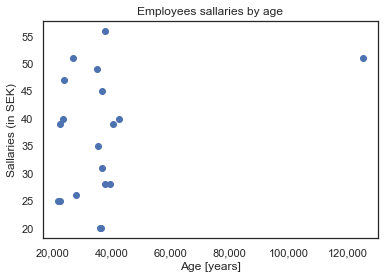

id pracownika: 9, wiek: 56, wypłata: 35500SEK
id pracownika: 8, wiek: 51, wypłata: 36500SEK
id pracownika: 15, wiek: 51, wypłata: 36000SEK
id pracownika: 19, wiek: 49, wypłata: 38000SEK
id pracownika: 10, wiek: 47, wypłata: 38000SEK
id pracownika: 18, wiek: 45, wypłata: 37000SEK
id pracownika: 14, wiek: 40, wypłata: 37000SEK
id pracownika: 11, wiek: 40, wypłata: 35000SEK

Nie widać zależności pomiędzy wiekiem a wypłatą.
Jest to zgodne z oczekiwaniami ponieważ dane były generowane losowo.


In [40]:
#połączenie z bazą
try:
	conn = mysql.connector.connect(
		user="team21",
		password="te@mZIP@ss",
		host="giniewicz.it",
		port=3306,
		database="team21"
	)
except mariadb.Error as e:
	print("Connection failed")
	sys.exit(1)

cur = conn.cursor()
#wywołanie zapytania
cur.execute(
	"SELECT employee_id, sallary, birth_date FROM employees ORDER BY birth_date asc"
)

#wpisanie pobranych danych do wektorów
sallaries_all=[]
age=[]
id=[]
current_date=datetime.date(2022,6,24)

for (employee_id, sallary, birth_date) in cur:
	sallaries_all.append(sallary)
	age.append(int(str((current_date-birth_date)/365).split(' ')[0]))
	id.append(employee_id)


#tworzenie wykresu
plt.plot(sallaries_all, age,'o')
plt.ylabel('Sallaries (in SEK)')
plt.xlabel('Age [years]')
plt.gca().xaxis.set_major_formatter(SMF('{x:,.0f}'))
plt.title('Employees sallaries by age')
plt.show()

#wypisanie danych
for i in range(len(sallaries)):
	print(f"id pracownika: {id[i]}, wiek: {age[i]}, wypłata: {sallaries[i]}SEK")
print("\nNie widać zależności pomiędzy wiekiem a wypłatą.\nJest to zgodne z oczekiwaniami ponieważ dane były generowane losowo.")


#zakończenie polączenia
conn.close()

## Zadanie 8

Ostatnim zagadnieniem jest sprawdzenie zależności skuteczności drużyny od tego, jak dużo się trenuje. Najpierw za pomocą kodu MySQL wybieramy dane z ilością treningów dla każdej drużyny z naszego klubu.


Następnie śgiągamy z bazy danych ilości zagranych meczy dlakażdej drużyny, oraz w analogiczny sposób krok póżniej ściągamy ilości wygranych meczy dla każdej drużyny.


Ostatecznie robimy wykres zależności efektywności w postaci procentu wygranych meczy od ilości treningów. Z wykresu możemy wyciągnąć wnioski czy taka zależność istnieje. W tym nam też pomoże wyliczenie współczynnika korelacji Pearsona.

In [41]:
#Connecting to database
if __name__ == "__main__":
    mydb = mysql.connector.connect(
        host = 'giniewicz.it',
        user = 'team21',
        database = 'team21',
        password = 'te@mZIP@ss'
    )
    mycursor = mydb.cursor()
    # ANALIZA 8
    #selecting number of trainings for each team
    sql = "SELECT \
    for_who, \
    COUNT(*) \
FROM trainings \
WHERE for_who IN (SELECT team FROM players) \
GROUP BY for_who;"
    mycursor.execute(sql)
    tmp = mycursor.fetchall()
    teams = [x[0] for x in tmp]
    trainings = [x[1] for x in tmp] 
    
    sql = "SELECT \
    team, COUNT(*) AS total_num \
    FROM (SELECT \
    team2 AS team, \
    CAST(team2_points AS signed)-CAST(team1_points AS signed) AS Diff \
FROM match_results \
WHERE place = 'home' \
UNION ALL \
SELECT \
    team1 AS team, \
    CAST(team1_points AS signed)-CAST(team2_points AS signed) AS Diff \
FROM match_results) AS results \
GROUP BY team;"
    mycursor.execute(sql)   #selecting count of matches for each team
    tmp = mycursor.fetchall()
    matches_num = [x[1] for x in tmp]
    
    sql = "SELECT \
    team, COUNT(*) AS win_num \
    FROM (SELECT \
    team2 AS team, \
    CAST(team2_points AS signed)-CAST(team1_points AS signed) AS Diff \
FROM match_results \
WHERE place = 'home' \
UNION ALL \
SELECT \
    team1 AS team, \
    CAST(team1_points AS signed)-CAST(team2_points AS signed) AS Diff \
FROM match_results) AS results \
WHERE Diff > 0 \
GROUP BY team;"
    mycursor.execute(sql)       #selecting count of match wins for each team
    tmp = mycursor.fetchall()
    wins_num = [x[1] for x in tmp]
    #making plot and finding correlation
    efficiency = [x/y for x,y in zip(wins_num, matches_num)]
    plt.scatter(trainings, efficiency)
    plt.title("Efficiency dependence from number of trainings")
    plt.xlabel("Number of trainings")
    plt.ylabel("Percent of matches won")
    plt.show()
    
    corr = stats.pearsonr(trainings, efficiency)[0]
    print("Pearson correlation between trainings and efficiency:", corr)

Pearson correlation between trainings and efficiency: -0.1487297097640156
